In [ ]:
from joblib import dump, load



In [ ]:
import numpy as np 
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import History
from sklearn import  metrics
from xgboost import XGBRegressor
from scipy.stats.distributions import uniform, randint

In [ ]:
fname = "./openpowerlifting.csv"
df = pd.read_csv(fname, parse_dates=True,low_memory=False)
df.head()

,Name,Sex,Event,Equipment,Age,AgeClass,Division,BodyweightKg,WeightClassKg,Squat1Kg,...,McCulloch,Glossbrenner,IPFPoints,Tested,Country,Federation,Date,MeetCountry,MeetState,MeetName
0,Abbie Murphy,F,SBD,Wraps,29.0,24-34,F-OR,59.8,60,80.0,...,324.16,286.42,511.15,NaN,NaN,GPC-AUS,2018-10-27,Australia,VIC,Melbourne Cup
1,Abbie Tuong,F,SBD,Wraps,29.0,24-34,F-OR,58.5,60,100.0,...,378.07,334.16,595.65,NaN,NaN,GPC-AUS,2018-10-27,Australia,VIC,Melbourne Cup
2,Ainslee Hooper,F,B,Raw,40.0,40-44,F-OR,55.4,56,NaN,...,38.56,34.12,313.97,NaN,NaN,GPC-AUS,2018-10-27,Australia,VIC,Melbourne Cup
3,Amy Moldenhauer,F,SBD,Wraps,23.0,20-23,F-OR,60.0,60,-105.0,...,345.61,305.37,547.04,NaN,NaN,GPC-AUS,2018-10-27,Australia,VIC,Melbourne Cup
4,Andrea Rowan,F,SBD,Wraps,45.0,45-49,F-OR,104.0,110,120.0,...,338.91,274.56,550.08,NaN,NaN,GPC-AUS,2018-10-27,Australia,VIC,Melbourne Cup


In [ ]:
df.shape

(1423354, 37)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16728 entries, 0 to 16727
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16728 non-null  object 
 1   Sex              16728 non-null  object 
 2   Event            16728 non-null  object 
 3   Equipment        16728 non-null  object 
 4   Age              16473 non-null  float64
 5   AgeClass         16474 non-null  object 
 6   Division         16728 non-null  object 
 7   BodyweightKg     16705 non-null  float64
 8   WeightClassKg    16697 non-null  object 
 9   Squat1Kg         11311 non-null  float64
 10  Squat2Kg         11137 non-null  float64
 11  Squat3Kg         10665 non-null  float64
 12  Squat4Kg         82 non-null     float64
 13  Best3SquatKg     11529 non-null  float64
 14  Bench1Kg         14908 non-null  float64
 15  Bench2Kg         14728 non-null  float64
 16  Bench3Kg         14101 non-null  float64
 17  Bench4Kg    

In [ ]:
#sprawdzamy ile % danego feature brakuje

lst = []
for cname in df.columns.tolist():
    percentage = round((100*df[cname].isna().sum()/df[cname].isna().count()), 2)
    lst.append((cname, percentage))

lst.sort(reverse=True, key = lambda x: x[1])

for element in lst:
    print(element[0] + ": " + str(element[1]) + "%")

Squat4Kg: 99.51%
Bench4Kg: 99.15%
Deadlift4Kg: 98.55%
Country: 62.95%
Tested: 48.81%
Squat3Kg: 36.24%
Squat2Kg: 33.42%
Squat1Kg: 32.38%
Best3SquatKg: 31.08%
Deadlift3Kg: 28.74%
MeetState: 26.03%
Deadlift2Kg: 24.93%
Deadlift1Kg: 23.37%
Best3DeadliftKg: 19.85%
Bench3Kg: 15.7%
Bench2Kg: 11.96%
Bench1Kg: 10.88%
IPFPoints: 9.85%
Best3BenchKg: 7.44%
Wilks: 3.53%
McCulloch: 3.53%
Glossbrenner: 3.53%
TotalKg: 3.39%
Age: 1.52%
AgeClass: 1.52%
WeightClassKg: 0.19%
BodyweightKg: 0.14%
Federation: 0.01%
Date: 0.01%
MeetCountry: 0.01%
MeetName: 0.01%
Name: 0.0%
Sex: 0.0%
Event: 0.0%
Equipment: 0.0%
Division: 0.0%
Place: 0.0%


In [ ]:
#pozbywamy sie wyników które chcemy przewidywać a także wszystkich innych featurów z których można wyliczyć squata
df = df.drop(["Squat1Kg", "Squat2Kg", "Squat3Kg", "TotalKg", "Place"], axis=1)
df = df.drop(["Wilks", "Glossbrenner", "IPFPoints", "McCulloch"], axis=1)
#usuwamy xxx4Kg bo występuje niezwykle rzadko 
#(jest to dodatkowe podejście przyznawane za jakiś błąd ze strony obsługi lub sędziów np. zawodnik miał założony zły ciężar)
df = df.drop(["Squat4Kg", "Deadlift4Kg", "Bench4Kg"], axis=1)
#ta sama informacja co Age i BodyWeightKg
df = df.drop(["AgeClass", "WeightClassKg"], axis=1)


In [ ]:
df.isna().any()

Name               False
Sex                False
Event              False
Equipment          False
Age                 True
Division           False
BodyweightKg        True
Best3SquatKg        True
Bench1Kg            True
Bench2Kg            True
Bench3Kg            True
Best3BenchKg        True
Deadlift1Kg         True
Deadlift2Kg         True
Deadlift3Kg         True
Best3DeadliftKg     True
Tested              True
Country             True
Federation          True
Date                True
MeetCountry         True
MeetState           True
MeetName            True
dtype: bool

In [ ]:
print(df["Event"].value_counts())
df = df.drop(["Event","MeetName"], axis=1)
# możemy usunąc nazwę zawodów i event bo nie chcemy żeby wpływały na predykcję
print(df["Name"].value_counts())
df = df.drop("Name", axis=1)
#usuniemy też imiona zawodników pomimo tego, że będzie to sprzyjać zbliżeniu predykcji 
#do wyników zawodników, którzy startowali wiele razy (przy tak dużej ilości zawodników nie powinno to stworzyć dużej różnicy)

SBD    1073237
B       257179
D        56717
BD       27598
S         4900
SB        2371
SD        1352
Name: Event, dtype: int64
Alan Aerts        214
Jose Hernandez    204
Sverre Paulsen    191
Erik Rasmussen    186
Bonnie Aerts      165
                 ... 
Matthew Rich        1
Matthew Russel      1
Gavin Chan          1
Quinn Troy          1
Jan Sowa            1
Name: Name, Length: 412574, dtype: int64


In [ ]:
# teraz pozbędziemy się wszystkich danych gdzie kluczowe feature są NaN 
# średnia byłaby tutaj słabym rozwiązaniem bo istnieje dużo zawodników startujących tylko dla jednego boju (szczególnie bench)
# i przynawanie im średniej byłoby dużym zawyżeniem ich prawdziwych wyników
columns = ["BodyweightKg", "Age", "Best3DeadliftKg", "Best3SquatKg", "Best3BenchKg"]

for col in columns:
    df = df.loc[(df[col].isna() == False) & (df[col] > 0)]

In [ ]:
print(df.isna().any())
# pozostałe NaN w 1,2,3Kg wynikają z niewykorzystanych podejść zawodników zastąpimy je danymi kategorycznymi
# jak łatwo się domyślić nie potrzeba tam dokładnych wyników bo ta sama informacja jest już w Best3Kg
# wystarczy nam informacja o ilości zaliczonych,spalonych i niewykorzystanych podejść
attemptCols = ["Deadlift1Kg", "Deadlift2Kg", "Deadlift3Kg", "Bench1Kg", "Bench2Kg", "Bench3Kg"]


def attemptTransformer(datapoint):
    if math.isnan(datapoint):
        return "Unknown"
    elif datapoint <= 0:
        return "Fail"
    else:
        return "Success"
    
for col in attemptCols:
    df[col] = df[col].apply(lambda x: attemptTransformer(x))
df.head()

Sex                False
Equipment          False
Age                False
Division            True
BodyweightKg       False
Best3SquatKg       False
Bench1Kg            True
Bench2Kg            True
Bench3Kg            True
Best3BenchKg       False
Deadlift1Kg         True
Deadlift2Kg         True
Deadlift3Kg         True
Best3DeadliftKg    False
Tested              True
Country             True
Federation         False
Date               False
MeetCountry        False
MeetState           True
dtype: bool


,Sex,Equipment,Age,Division,BodyweightKg,Best3SquatKg,Bench1Kg,Bench2Kg,Bench3Kg,Best3BenchKg,Deadlift1Kg,Deadlift2Kg,Deadlift3Kg,Best3DeadliftKg,Tested,Country,Federation,Date,MeetCountry,MeetState
0,F,Wraps,29.0,F-OR,59.8,105.0,Success,Success,Success,55.0,Success,Success,Success,130.0,NaN,NaN,GPC-AUS,2018-10-27,Australia,VIC
1,F,Wraps,29.0,F-OR,58.5,120.0,Success,Success,Success,67.5,Success,Success,Success,145.0,NaN,NaN,GPC-AUS,2018-10-27,Australia,VIC
3,F,Wraps,23.0,F-OR,60.0,105.0,Success,Success,Fail,72.5,Success,Fail,Fail,132.5,NaN,NaN,GPC-AUS,2018-10-27,Australia,VIC
4,F,Wraps,45.0,F-OR,104.0,140.0,Success,Success,Success,80.0,Success,Success,Success,170.0,NaN,NaN,GPC-AUS,2018-10-27,Australia,VIC
5,F,Wraps,37.0,F-OR,74.0,142.5,Success,Success,Success,82.5,Success,Success,Success,145.0,NaN,NaN,GPC-AUS,2018-10-27,Australia,VIC


In [ ]:
#Zostaje nam division, tested, country i MeetState
print(df["Tested"])
#w tested wystarczy zamienić NaN na informacje o tym że osoba nie była testowana np "No"
df["Tested"] = df["Tested"].fillna("No")

# w pozostałych przypadkach po prostu zamienimy je na missing value
from sklearn.impute import SimpleImputer

simpImputeCols = ["Country", "MeetState", "Division"]

simpImputer = SimpleImputer(strategy="constant")
df[simpImputeCols] = simpImputer.fit_transform(df[simpImputeCols])


0          NaN
1          NaN
3          NaN
4          NaN
5          NaN
          ... 
1423347    Yes
1423348    Yes
1423349    Yes
1423350    Yes
1423351    Yes
Name: Tested, Length: 468843, dtype: object


In [ ]:
#Teraz nie mamy już żadnych NaN
print(df.isna().any())
df.index = np.arange(df.shape[0])

Sex                False
Equipment          False
Age                False
Division           False
BodyweightKg       False
Best3SquatKg       False
Bench1Kg           False
Bench2Kg           False
Bench3Kg           False
Best3BenchKg       False
Deadlift1Kg        False
Deadlift2Kg        False
Deadlift3Kg        False
Best3DeadliftKg    False
Tested             False
Country            False
Federation         False
Date               False
MeetCountry        False
MeetState          False
dtype: bool


In [ ]:
#Oddzielamy features od przewidywanej wartości
X = df.drop("Best3SquatKg", axis=1)
y = df["Best3SquatKg"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


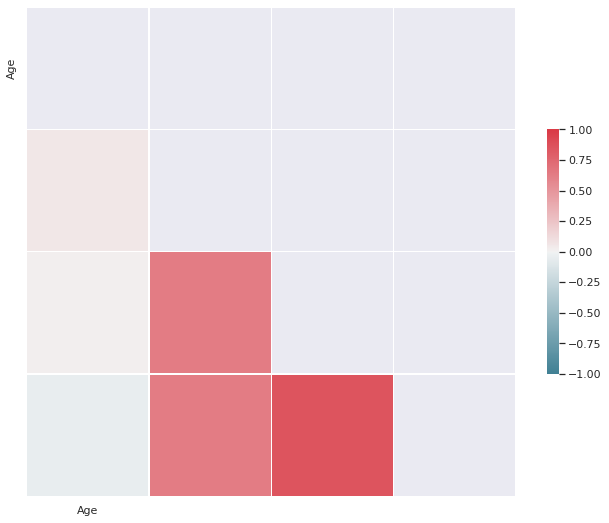

,Age,BodyweightKg,Best3BenchKg,Best3DeadliftKg
Age,1.000000,0.054748,0.022350,-0.039138
BodyweightKg,0.054748,1.000000,0.638698,0.633433
Best3BenchKg,0.022350,0.638698,1.000000,0.852644
Best3DeadliftKg,-0.039138,0.633433,0.852644,1.000000


In [ ]:
# zobaczymy heatmape dla numerycznych features
numColumns = [col for col in X.columns.tolist() if X[col].dtype == "float64"]

sns.set(style="darkgrid")

corr = X[numColumns].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.show()
corr


In [ ]:
#sns.lineplot(x=X["Date"], y=y, linewidth=.1, estimator='mean')
# nie widać zależności wyników od czasu więc możemy pozbyć się daty zawodów

In [ ]:
catColumns = [col for col in X.columns.tolist() if X[col].dtype == "object"]
X = X.drop("Date", axis=1)
catColumns.remove("Date")
for col in catColumns:
    print(col + ": " + str(df[col].nunique()))


#Jak widac mamy kilka kategorycznych feature ktorych nie mozemy zonehotencodowac bo jest zbyt duzo unique values

Sex: 2
Equipment: 4
Division: 3318
Bench1Kg: 3
Bench2Kg: 3
Bench3Kg: 3
Deadlift1Kg: 3
Deadlift2Kg: 3
Deadlift3Kg: 3
Tested: 2
Country: 142
Federation: 196
MeetCountry: 92
MeetState: 110


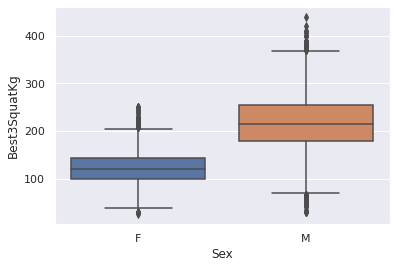

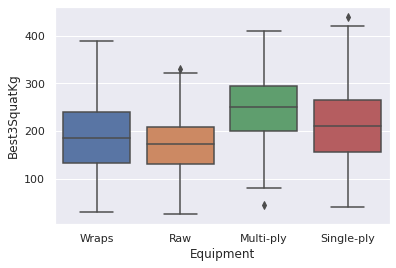

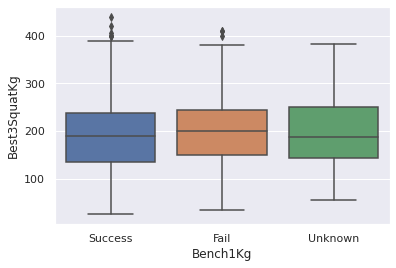

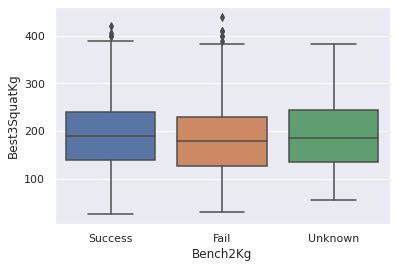

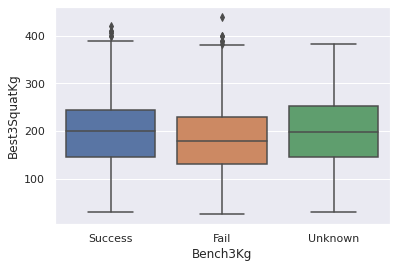

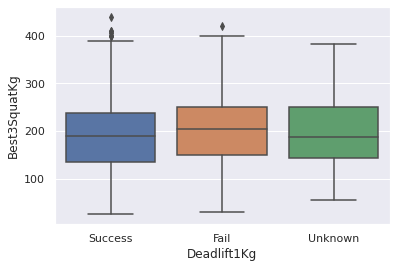

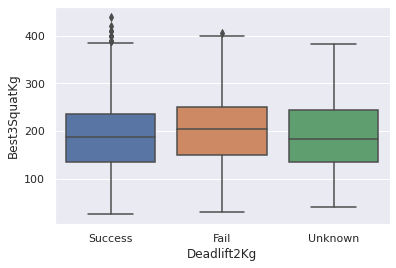

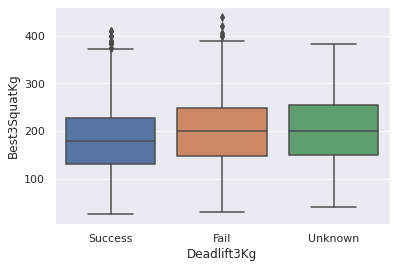

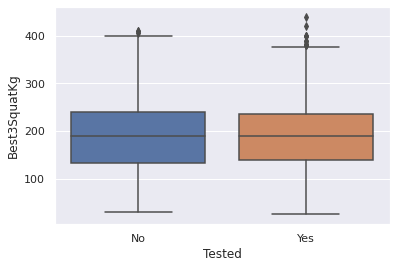

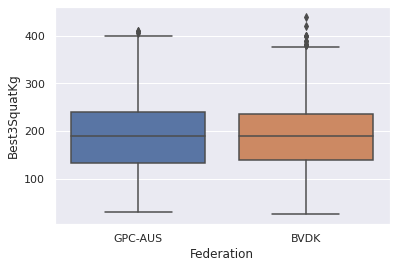

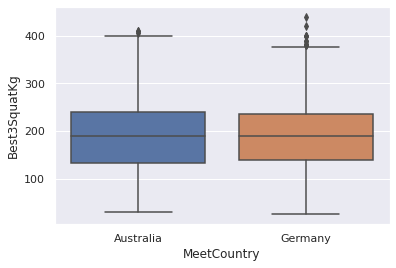

In [ ]:
for name in catColumns:
    if X[name].nunique() < 15:
        sns.boxplot(x=X[name], y=y)
        plt.show()

In [ ]:
hotEncode = ["Sex", "Equipment", "Tested", "Deadlift1Kg", "Deadlift2Kg", "Deadlift3Kg", "Bench1Kg", "Bench2Kg", "Bench3Kg"]

## one hot encoding
def oneHotEncode(X,hotEncode):  
    for col in hotEncode:
        X1 = pd.get_dummies(X[col], prefix=col)
        X = pd.concat([X, X1], axis=1)
        X= X.drop(col, axis=1)
    return (X)




In [ ]:
targetEncode = ["Division", "Country", "Federation", "MeetCountry", "MeetState"]

#target encoding dopiero po train test split
scaler =StandardScaler()
X[numColumns] = scaler.fit_transform(X[numColumns])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

enc = TargetEncoder(cols=targetEncode, handle_missing="value", handle_unknown="value")

X_train = oneHotEncode(X_train,hotEncode)
X_train = enc.fit_transform(X_train, y_train)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1) 

X_test = oneHotEncode(X_test,hotEncode)
X_val = oneHotEncode(X_val,hotEncode)

X_val = enc.transform(X_val)
X_test = enc.transform(X_test)


/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:94: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:99: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)


In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

param_grid={"C": [0.001, 0.01, 0.1, 1, 10 ,100, 1000, 10000, 100000,1000000],
                               "gamma": [0.00001,0.0001,0.001, 0.01, 0.1, 1, 10 ,100, 1000]}

grid_1 = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=kfold, return_train_score=True,verbose=3)

grid_1.fit(X_val, y_val)
grid_1.best_params_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END C=100000, gamma=1e-05;, score=(train=0.887, test=0.882) total time=  15.1s
[CV 2/5] END C=100000, gamma=1e-05;, score=(train=0.884, test=0.895) total time=   8.9s
[CV 3/5] END C=100000, gamma=1e-05;, score=(train=0.889, test=0.875) total time=   8.4s
[CV 4/5] END C=100000, gamma=1e-05;, score=(train=0.889, test=0.875) total time=   9.3s
[CV 5/5] END C=100000, gamma=1e-05;, score=(train=0.884, test=0.896) total time=   9.4s
[CV 1/5] END C=100000, gamma=0.0001;, score=(train=0.892, test=0.879) total time=  29.5s
[CV 2/5] END C=100000, gamma=0.0001;, score=(train=0.888, test=0.895) total time=  22.0s


KeyboardInterrupt: ignored

In [ ]:
param_distribution = {
    'max_depth': randint(3, 11),
    'learning_rate': uniform(0.001, 0.1-0.001),
    'n_estimators': randint(50, 400),
    'gamma': uniform(0,2),
    'colsample_bytree': uniform(0.5, 0.5),
    'subsample': uniform(0.5, 0.5),
    'min_child_weight': randint(1, 11)
}
random_XGB = RandomizedSearchCV(XGBRegressor(),param_distribution,n_jobs=-1,verbose=3)
random_XGB.fit(X_val,y_val)
print(random_XGB.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[23:15:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'colsample_bytree': 0.5190979823846726, 'gamma': 1.3648949762038143, 'learning_rate': 0.014733180752348425, 'max_depth': 5, 'min_child_weight': 8, 'n_estimators': 315, 'subsample': 0.9624894277145091}


In [ ]:


model_SVR = SVR(C=100000,gamma=0.00001,verbose=True)
model_SVR.fit(X_train,y_train)

In [ ]:
model_XGB = XGBRegressor(colsample_bytree=0.5190979823846726, gamma= 1.3648949762038143, learning_rate= 0.014733180752348425, 
                         max_depth= 5, min_child_weight= 8, n_estimators= 315, subsample= 0.9624894277145091,verbose=True)
model_XGB.fit(X_train,y_train)

[00:43:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
#dump(model_SVR,'model_SVR.joblib')
#dump(grid_SVR,'grid_SVR.joblib')
#dump(random_XGB,'random_XGB.joblib')
#dump(model_XGB,'model_XGB.joblib')
models = []

models.append(('SVR', model_SVR))
models.append(('XGB', model_XGB))


for name, model in models:
    print(name)
    print("R^2: {}".format(metrics.r2_score(y_test, model.predict(X_test)) ))
    print("Explained variance score: {}".format( metrics.explained_variance_score(y_test, model.predict(X_test)) ))
    print("Median absolute error: {}".format( metrics.median_absolute_error(y_test, model.predict(X_test)) ))
    print("Mean squared error: {}".format( metrics.mean_squared_error(y_test, model.predict(X_test)) ))
    print("Mean absolute errors: {}".format(metrics.mean_absolute_error(y_test, model.predict(X_test)) ))

SVR
R^2: 0.7980388029013953


KeyboardInterrupt: ignored

13127590


In [ ]:
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Dense
from keras.callbacks import EarlyStopping

model = Sequential()

model = Sequential()
model.add(Dense(320, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(384, activation='relu'))
model.add(Dense(352, activation='relu'))
model.add(Dense(448, activation='relu'))
model.add(Dense(160, activation='relu'))
model.add(Dense(160, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1,activation='relu'))


model.summary()

model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])
          
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 320)               11520     
                                                                 
 dense_23 (Dense)            (None, 384)               123264    
                                                                 
 dense_24 (Dense)            (None, 352)               135520    
                                                                 
 dense_25 (Dense)            (None, 448)               158144    
                                                                 
 dense_26 (Dense)            (None, 160)               71840     
                                                                 
 dense_27 (Dense)            (None, 160)               25760     
                                                                 
 dense_28 (Dense)            (None, 32)               

In [ ]:
history = model.fit(X_train, y_train,
          batch_size=128, epochs=30, validation_data=(X_val, y_val), callbacks=[early_stop])

Epoch 1/30
70/70 [==============================] - 2s 20ms/step - loss: 40638.3164 - accuracy: 0.0000e+00 - val_loss: 39743.6289 - val_accuracy: 0.0000e+00
Epoch 2/30
70/70 [==============================] - 1s 17ms/step - loss: 40638.3125 - accuracy: 0.0000e+00 - val_loss: 39743.6289 - val_accuracy: 0.0000e+00
Epoch 3/30
70/70 [==============================] - 1s 17ms/step - loss: 40638.3125 - accuracy: 0.0000e+00 - val_loss: 39743.6289 - val_accuracy: 0.0000e+00
Epoch 4/30
70/70 [==============================] - 1s 17ms/step - loss: 40638.3281 - accuracy: 0.0000e+00 - val_loss: 39743.6289 - val_accuracy: 0.0000e+00
Epoch 5/30
70/70 [==============================] - 1s 17ms/step - loss: 40638.3164 - accuracy: 0.0000e+00 - val_loss: 39743.6289 - val_accuracy: 0.0000e+00
Epoch 6/30
70/70 [==============================] - 1s 17ms/step - loss: 40638.3203 - accuracy: 0.0000e+00 - val_loss: 39743.6289 - val_accuracy: 0.0000e+00
Epoch 7/30
70/70 [==============================] - 1s 15m